Denoising fMRI data using aCompCor and time-series extraction and task signal regression
================================================

This a script for group denoising and timeseries extraction from on longitudinal fMRI data preprocessed in fmriprep.

Last edit: 02.08.2017

Step 1: Importing packages
------------------------------------------

In [1]:
%reset
%matplotlib inline

from os import listdir
import os


import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn import preprocessing # for normalization of confounds columns

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn import signal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

from fctools import denoise

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Step 2: Create design matrix
--------------------------------------

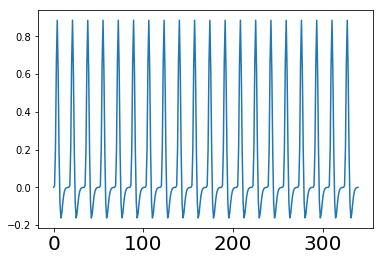

In [4]:
from nistats.reporting import plot_design_matrix
from nistats.design_matrix import make_design_matrix

t_r = 2
n_scans = 340

onsets_dir = '/home/finc/Dropbox/sub-02/onsets_dualnback.csv'

events = pd.read_csv(onsets_dir)
events

frame_times = np.arange(n_scans) * t_r
frame_times

design_matrix = make_design_matrix(frame_times, events, hrf_model = 'glover')
design_matrix = design_matrix.reset_index()

plt.plot(design_matrix['intro'])

Step 3: Creating atlas
-------------------------------------------

In [8]:
# Loading Power ROIs coordinates

power = datasets.fetch_coords_power_2011()
power_coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T

# Creating masker file

power_spheres = input_data.NiftiSpheresMasker(
    seeds = power_coords, 
    smoothing_fwhm = 6, 
    radius = 5,
    detrend = True, 
    standardize = True,
    low_pass = None,
    #high_pass = None,
    #low_pass = 0.08, 
    high_pass = 0.009,
    t_r = 2
)

parcellation = power_spheres


Step 4: Loading data
-----------------------

In [9]:
# Selecting subjects which finished the study

groups = pd.read_csv('/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]['sub']
subs = pd.Series.tolist(trained_subs)
subs[:5]


['sub-01', 'sub-02', 'sub-04', 'sub-05', 'sub-06']

In [10]:
# Loading functional data
top_dir = '/media/finc/Elements/LearningBrain_fmriprep/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/'

sess = ['ses-1', 'ses-2', 'ses-3', 'ses-4']
#tasks = ['rest']
tasks = ['dualnback']
#subs = listdir(top_dir)

suffix = 'space-MNI152NLin2009cAsym_preproc.nii.gz'
#suffix = 'space-MNI152NLin2009cAsym_variant-smoothAROMAnonaggr_preproc.nii.gz'


Step 5: Obtaining timeseries from ROIs - 1-back & instruction regressed out
------------------------------------------------------------------------
Creating 5D matrix with mean timeseries within each ROI 

In [14]:
#subs = listdir(top_dir)

timeseries_all = np.zeros((len(subs), len(sess), 340, 264))

for sub in range(len(subs)):
    for ses in range(len(sess)):
        for task in range(len(tasks)):
            
            sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
            sub_name = subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] 
            data = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_' + suffix
            
            # Loading confound data
            confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            
            if not os.path.exists(confounds_path):
                print(f"{subs[sub]} {sess[ses]} {tasks[task]} does not exist")
            else:
    
            
                confounds = pd.read_csv(confounds_path, delimiter = '\t')
                confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

                # Select columns of interest 
                confounds_motion = confounds[confounds.filter(regex = 'X|Y|Z|RotX|RotY|RotZ').columns]
                confounds_anat = confounds[confounds.filter(regex = 'CSF|WhiteMatter|aCompCor').columns]
                confounds_fd =  confounds[confounds.filter(regex = 'Framewise').columns]

                # Calculate 24 fristom motion parameters
                confounds_motion_24 =  denoise.motion_24_friston(confounds_motion)

                # Detect outliers 
                confounds_scrub = denoise.scrubbing(confounds_fd, before = False)

                # Standardize confounds
                confounds_anat = denoise.standardize(confounds_anat)

                # Add scrubbing columns
                confounds_clean = pd.concat([confounds_anat, confounds_motion_24, confounds_scrub, pd.DataFrame(design_matrix, columns = ['1-back', '2-back', 'intro'])], axis = 1)

                # Save preprocessed confound file
                confounds_clean.to_csv(out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv', sep = ',', index = False)
                confounds_clean_path = out_dir + 'confounds/' + sub_name + '_clean_acompcor.csv'

                timeseries = parcellation.fit_transform(data, confounds = confounds_clean_path)

                timeseries_all[sub, ses, :, :] = timeseries
            
np.save(out_dir + 'neuroimaging/' + 'LearningBrain_' + tasks[task] + '_timeseries_hp_0.009_aCompCor_power_conn_style.npy', timeseries_all)

/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/notebooks/fctools/denoise.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_td'] = temp_diff
/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/notebooks/fctools/denoise.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  motion_24_friston[col + '_sqrt'] = sqrt
/home/finc/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [7]:
# Loading confound data
confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            
confounds = pd.read_csv(confounds_path, delimiter = '\t')
confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

NameError: name 'sub_dir' is not defined

In [12]:
sub = 0
ses = 0
task = 0

In [41]:
# Loading confound data

sub_dir = top_dir + subs[sub] + '/' + sess[ses] + '/func/'
sub_name = subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] 

confounds_path = sub_dir + subs[sub] + '_' + sess[ses] + '_task-' + tasks[task] + '_bold_confounds.tsv'
            
confounds = pd.read_csv(confounds_path, delimiter = '\t')
confounds.to_csv(out_dir + 'confounds/' + sub_name + '_bold_confounds.csv', sep = ',', index = False)

x = pd.concat([confounds, pd.DataFrame(design_matrix, columns = ['1-back'])], axis = 1)

,1-back,intro
0,0.000000,0.000000
1,0.000000,0.009125
2,0.000000,0.203780
3,0.009125,0.659859
4,0.203780,0.884470
5,0.668984,0.607048
6,1.088250,0.187650
7,1.276032,-0.079605
8,1.275900,-0.162115
9,1.196428,-0.139833
